In [1]:
import os,sys,string, time
import ROOT
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import pickle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')


Welcome to JupyROOT 6.24/06
Success


In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_lepton_signal":False, #Load ee BDTs
          "Load_pi0_signal":False, #Load pi0 BDTs
          "Use_logit":True} 

loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Constants.Detector_variations
        
sample_test_dict = {}
for sample in samples:
    loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs_FINAL.pkl"
    sample_test_dict[sample] = pd.read_pickle(loc)
print("Loaded all " + Params["Run"] + " overlay detector variation samples.")

Loaded all run1 overlay detector variation samples.


In [3]:
if Params["Load_pi0_signal"] == False: BDT_name = "ee_FINAL_2"
if Params["Load_pi0_signal"] == True: BDT_name = "pi0_FINAL_2"

if Params["Load_pi0_signal"] == False:
    with open(f"bdts/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
elif Params["Load_pi0_signal"] == True:
    with open(f"bdts/pi0_selection/input_vars/{BDT_name}_"+Params["Run"], "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)

bdt_vars = saved_variables
xgb_test_dict = {}

for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    
if Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        bdt = xgboost.Booster()
        # bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json")
        bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_" + BDT_name+".json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        bdt = xgboost.Booster()
        bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}MeV_pi0_{BDT_name}.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

In [4]:
def Save_one_hist(hist,name,nbins,xlims):
    # tData = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
    tData = ROOT.TH1F(name,name,len(nbins)-1,array("d",nbins))
    for i in range(len(nbins)-1):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    for name in hist_samples:
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    #rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [5]:
def safe_div(x,y):
    if y == 0.0:
        return 0
    return x / y

def Calc_RMS_quadsum(CV_hist, dict_detvar_hists): #Currently assuming "mean" value to be the CV, I believe this is the correct thing to do
    nbins = len(CV_hist)
    RMS_on_bins = np.zeros(nbins)
    Quad_sum_on_bins = np.zeros(nbins)
    RMS_on_bins_frac = np.zeros(nbins)
    Quad_sum_on_bins_frac = np.zeros(nbins)
    num_samples = len(dict_detvar_hists) #This should NOT include the CV hist
    for j in range(nbins): #Looping over bins
        sum_diffs_squared = 0
        for detvar in dict_detvar_hists:
            diff = dict_detvar_hists[detvar][j]-CV_hist[j] #Difference between the number in the CV sample and the DetVar sample
            sum_diffs_squared += diff**2
        variance = sum_diffs_squared/num_samples
        RMS_on_bins[j] = np.sqrt(variance) #The total RMS error on the bin
        Quad_sum_on_bins[j] = np.sqrt(sum_diffs_squared)
        RMS_on_bins_frac[j] = safe_div(np.sqrt(variance),CV_hist[j]) #Need to calculate here to avoid problems with zero divisor
        Quad_sum_on_bins_frac[j] = safe_div(np.sqrt(sum_diffs_squared),CV_hist[j])
              
    return {"RMS":RMS_on_bins, "quadsum":Quad_sum_on_bins, "RMS_frac":RMS_on_bins_frac, "quadsum_frac":Quad_sum_on_bins_frac}

def Calc_frac_diff(CV_hist, dict_detvar_hists):
    nbins = len(CV_hist)
    frac_diff_dict = {}
    perc_diff_dict = {}
    for detvar in dict_detvar_hists: #Should NOT contain CV hist
        frac_diff_on_bins = np.zeros(nbins)
        perc_diff_on_bins = np.zeros(nbins)
        for j in range(nbins): #Looping over bins
            frac = safe_div(dict_detvar_hists[detvar][j],CV_hist[j])
            frac_diff = frac - 1.0
            perc_diff = (frac_diff*100)
            frac_diff_on_bins[j] = frac_diff
            perc_diff_on_bins[j] = perc_diff
        frac_diff_dict[detvar] = frac_diff_on_bins
        perc_diff_dict[detvar] = perc_diff_on_bins
           
    return frac_diff_dict, perc_diff_dict

def Calc_stat_err(CV_hist, CV_hist_unweighted): #Calculate the statistical (Poisson) error on each bin for the central value histogram
    nbins = len(CV_hist)
    stat_err_on_bins = np.zeros(nbins)
    for j in range(nbins): #Looping over bins
        poisson_err = np.sqrt(CV_hist_unweighted[j])
        SF = CV_hist_unweighted[j]/CV_hist[j] #The factor this bin is scaled by due to weighting
        stat_err_on_bins[j] = poisson_err*SF #Need to scale the Poisson error by whatever the total scaling on the bin is
    return stat_err_on_bins

## Plotting overlay Detector variations

In [6]:
bins_dict = {}
filename = 'FINAL_2.root'

if Params["Load_pi0_signal"] == False:
    HNL_masses = Constants.HNL_mass_samples
    saved_loc = f'bdt_output/'
if Params["Load_pi0_signal"] == True:
    HNL_masses = Constants.HNL_mass_pi0_samples
    saved_loc = f'bdt_output/pi0/'
    
for HNL_mass in HNL_masses:
    hist_placeholder = uproot.open(saved_loc+Params["Run"]+f'_{HNL_mass}MeV_'+filename)
    bins_dict[HNL_mass] = hist_placeholder['bkg_overlay'].to_numpy()[1] #A tuple of bin edges
print("Loaded bins for " + str(bins_dict.keys()))

Loaded bins for dict_keys([2, 10, 20, 50, 100, 150])


In [7]:
sample_test_dict.keys()

dict_keys(['WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV'])

Plotting 2MeV histogram
Plotting 10MeV histogram
Plotting 20MeV histogram
Plotting 50MeV histogram
Plotting 100MeV histogram
Plotting 150MeV histogram


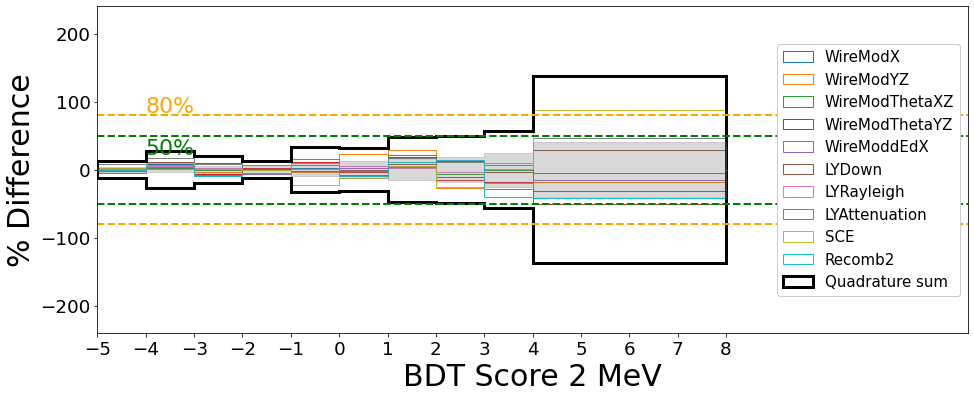

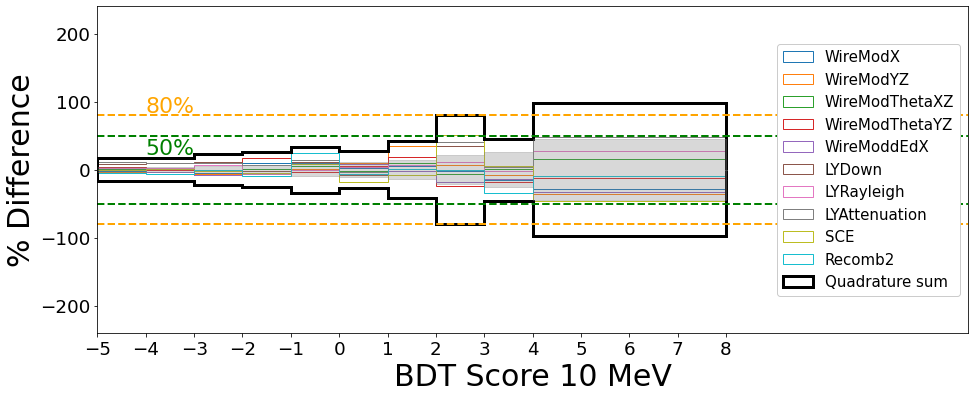

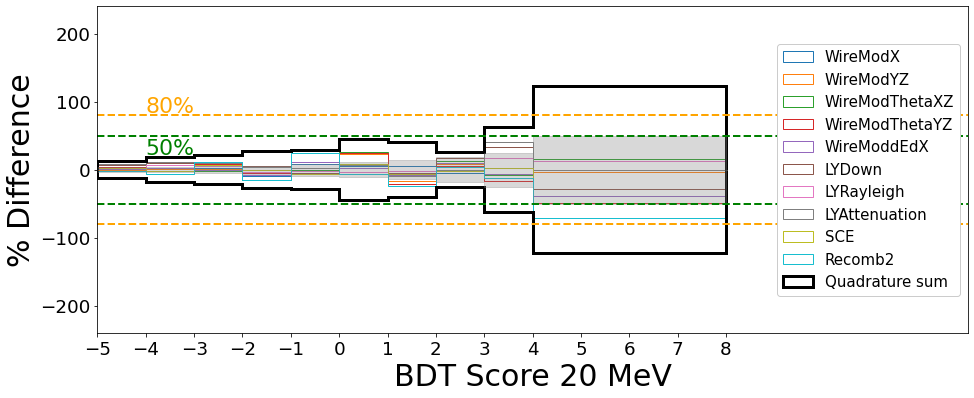

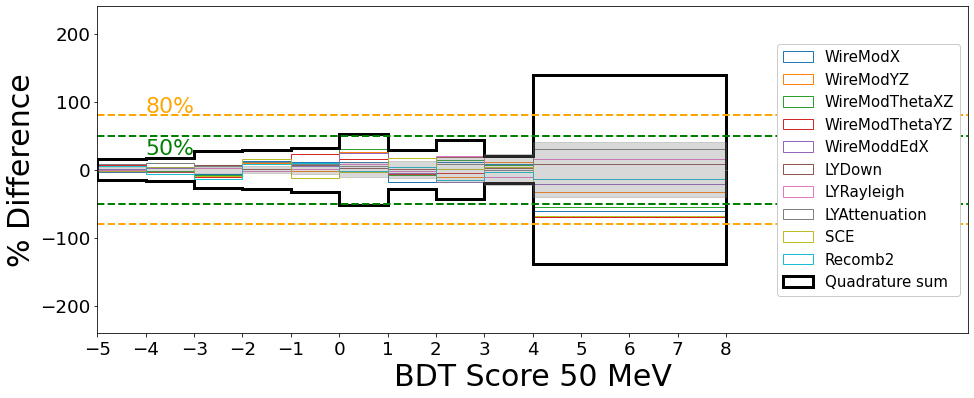

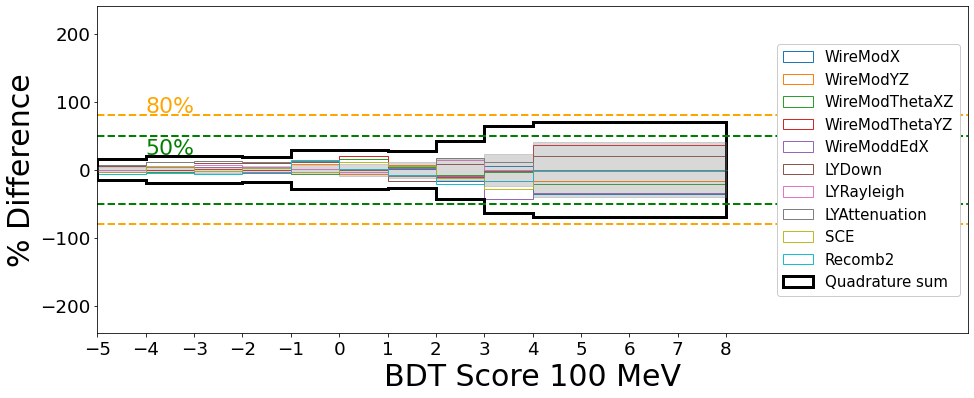

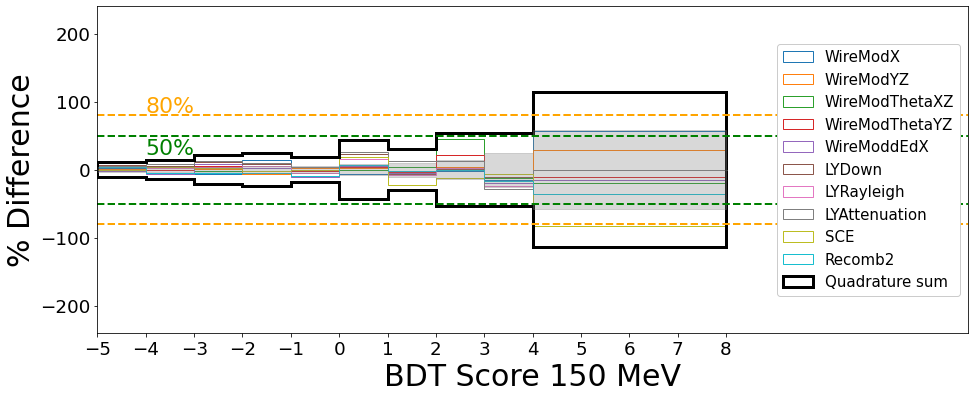

In [8]:
# Want to swap this out for the neater script below. However, below currently getting problems with zero divisors and not plotting merged bins
DetVar_percentages_dict = {}
savefig = False
display = True

figsize=(14, 6)
linewidth = 1
h_line_1 = 50 #Line displaying this % difference
h_line_2 = 80

for HNL_mass in HNL_masses: #Looping over all mass points
    
    print(f"Plotting {HNL_mass}MeV histogram") 
    if Params["Use_logit"] == True:
        bins = bins_dict[HNL_mass]
        nbins = len(bins)-1
        xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
        # xlims = [-0.5, 7]
        # xticks = [0, 1, 2, 3, 4, 5]
        xlims = [bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+5]
        xticks = np.arange(bins_dict[HNL_mass][0],bins_dict[HNL_mass][-1]+1)
    else:
        bins = np.linspace(0,1, 11)
        nbins = len(bins)-1
        xrange = [bins[0], bins[-1]]
        xlims = [0,1.4]
        xticks = [0, 0.2, 0.4, 0.8, 1.0]
    
    plt.figure(figsize=figsize,facecolor='white')
    RMS=np.zeros(nbins)
    frac_RMS=np.zeros(nbins)
    quad_sum=np.zeros(nbins)
    frac_quad_sum=np.zeros(nbins)
    sum_squares = np.zeros(nbins)
    stat_err = np.zeros(nbins)
    SF_on_bin = np.zeros(nbins)
    upvals = np.zeros(nbins+1)
    lowvals = np.zeros(nbins+1)
    upvals_frac = np.zeros(nbins+1)
    lowvals_frac = np.zeros(nbins+1)
    x_coords = bins_dict[HNL_mass]
    max_y = 0
    
    if Params["Use_logit"] == False:
        cv_hist, cv_bins = np.histogram(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=xrange,
        bins=nbins,
        weights=sample_test_dict["CV"]["weight"])
    if Params["Use_logit"] == True:
        cv_hist, cv_bins = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=bins,
        weights=sample_test_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        perc_list = []
        if Params["Use_logit"] == False:
            detvar_hist, bins = np.histogram(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
            range=xrange,
            bins=nbins,
            weights=sample_test_dict[DetVar]["weight"])
        if Params["Use_logit"] == True:
            detvar_hist, bins = np.histogram(Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']),
            range=xrange,
            bins=bins,
            weights=sample_test_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = safe_div(detvar_hist[i],cv_hist[i])
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=bins,range=xrange,label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
        
    cv_no_weighting = np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),
        range=xrange,
        bins=bins)[0]
    
    for j in range(len(cv_hist)):
        for DetVar in Constants.Detector_variations:
            if DetVar == "CV":
                continue
            if Params["Use_logit"] == False:
                hist_input = sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV']
            if Params["Use_logit"] == True:
                hist_input = Functions.logit(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'])
                    
            detvar_hist, bins = np.histogram(hist_input,
                                             range=xrange, 
                                             bins=bins, 
                                             weights=sample_test_dict[DetVar]["weight"])
            
            diff = cv_hist[j] - detvar_hist[j]
            diff_squared = diff**2
            sum_squares[j] = sum_squares[j]+diff_squared
            
            # SF_on_bin[j] = cv_hist[j]/cv_no_weighting[j] #This effective scale factor comes in by weighting on events
            SF_on_bin[j] = safe_div(cv_hist[j],cv_no_weighting[j])
            stat_err[j] = np.sqrt(cv_no_weighting[j])*SF_on_bin[j]
            upvals[j] = cv_hist[j]+stat_err[j]
            lowvals[j] = cv_hist[j]-stat_err[j]
            upvals_frac[j] = safe_div(upvals[j],cv_hist[j])*100-100
            lowvals_frac[j] = safe_div(lowvals[j],cv_hist[j])*100-100
        
        RMS[j] = np.sqrt(sum_squares[j]/(len(Constants.Detector_variations)-1))
        frac_RMS[j] = safe_div(RMS[j],cv_hist[j])
        quad_sum[j] = np.sqrt(sum_squares[j])
        frac_quad_sum[j] = safe_div(quad_sum[j],cv_hist[j])#quad_sum[j]/cv_hist[j]
    # max_y = max(frac_quad_sum)
    max_y = 2
    
    # print(max_y)
    ylims = [max_y*(-1.2)*100, max_y*(1.2)*100]
    plt.hist(bins_cent, weights=frac_quad_sum*100, bins=bins,range=xrange,label=f'Quadrature sum',lw=linewidth+2,
             histtype="step", color="black")
    plt.hist(bins_cent, weights=frac_quad_sum*(-100), bins=bins,range=xrange,lw=linewidth+2,
             histtype="step", color="black")
    
    # plt.hist(bins_cent, weights=frac_RMS*100, bins=bins,range=xrange,label=f'RMS',lw=linewidth+2,
    #          histtype="step", color="black")
    # plt.hist(bins_cent, weights=frac_RMS*(-100), bins=bins,range=xrange,lw=linewidth+2,
    #          histtype="step", color="black")
    
    if Params["Use_logit"] == True:plt.fill_between(x_coords, lowvals_frac, upvals_frac, step="post",color="grey",alpha=0.3,zorder=2)
    
    plt.legend(loc='center right',frameon=True, framealpha=1.0)
    plt.ylim(ylims)
    plt.xlim(xlims) #Goes up to 7 to leave space for the legend
    # plt.xlim([-5, 9]) #Goes up to 7 to leave space for the legend
    plt.xlabel(f'BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    
    if max_y*100 > h_line_1:
        plt.axhline(y=h_line_1, lw=2, color='green', linestyle = 'dashed')
        plt.axhline(y=-1*(h_line_1), lw=2, color='green', linestyle = 'dashed')
        plt.text(-4, 22, "50%", color='green')
    
    if max_y*100 > h_line_2:
        plt.axhline(y=h_line_2, lw=2, color='orange', linestyle = 'dashed')
        plt.axhline(y=-1*(h_line_2), lw=2, color='orange', linestyle = 'dashed')
        plt.text(-4, 85, "80%", color='orange')
    
    plt.xticks(xticks) #Only keeping values for BDT scores which are possible.
    # plt.xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]) #Only keeping values for BDT scores which are possible.
    #plt.yscale()
    plt.tight_layout()
    if savefig == True:
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/bkg_DetVars_" + Params["Run"] + "_" + str(HNL_mass) + "MeV_FINAL.pdf")
        plt.savefig("plots/Sys_uncertainty/Overlay/DetVar/bkg_DetVars_" + Params["Run"] + "_" + str(HNL_mass) + "MeV_FINAL.png")
    if display == False:
            plt.close()

In [ ]:
flat_overlay_detvar = 0.5 #The fraction of overlay detector variation error
flat_signal_detvar = 0.15 #The fraction of signal detector variation error
overlay_detvar_dict, overlay_detvar_frac_dict = {}, {}
signal_detvar_dict, signal_detvar_frac_dict = {}, {}

loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"

for HNL_mass in HNL_masses:
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}MeV_'+filename) as file:
        bkg_vals_placeholder=file['bkg_overlay'].values()
        signal_vals_placeholder=file['signal'].values()
    overlay_detvar_dict[HNL_mass] = bkg_vals_placeholder*flat_overlay_detvar
    signal_detvar_dict[HNL_mass] = signal_vals_placeholder*flat_signal_detvar
    overlay_detvar_frac_dict[HNL_mass] = np.ones_like(bkg_vals_placeholder)*flat_overlay_detvar
    signal_detvar_frac_dict[HNL_mass] = np.ones_like(signal_vals_placeholder)*flat_signal_detvar

## Saving .root files with DetVar uncertainties

In [ ]:
loc_hists = "Uncertainties/"
if Params["Load_pi0_signal"] == True: loc_hists=loc_hists+"pi0/"

for HNL_mass in HNL_masses:
    bins_cent=(bins_dict[HNL_mass][:-1]+bins_dict[HNL_mass][1:])/2

    values_dict = {'overlay_DetVar_uncertainty': overlay_detvar_dict[HNL_mass], 
                   'overlay_DetVar_uncertainty_frac': overlay_detvar_frac_dict[HNL_mass], 
                   'signal_DetVar_uncertainty':signal_detvar_dict[HNL_mass],
                   'signal_DetVar_uncertainty_frac':signal_detvar_frac_dict[HNL_mass]} 
    hist_samples = {}

    #make array with all values 1, then weight by value
    for name in values_dict:
        test_hist = np.histogram(bins_cent, weights=values_dict[name], bins=bins_dict[HNL_mass], 
                                 range=[bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]])
        hist_samples[name] = test_hist

    stop_writing = False
    dont_save = []
    with uproot.open(loc_hists+Params["Run"]+f'_{HNL_mass}MeV_'+filename) as file: #Check what is already in the file (read-only)
        for name in hist_samples:
            if str(name)+";1" in file.keys():
                dont_save.append(name)

    with uproot.update(loc_hists+Params["Run"]+f'_{HNL_mass}MeV_'+filename) as file: #Add new hists into the file
        for name in hist_samples:
            if name in dont_save:
                print(f"Not saving {name}")
            else:
                file[name] = hist_samples[name]
                
print("Done")

## End of code

## Printing specific bin numbers

In [ ]:
for HNL_mass in HNL_masses:
    print(f"{HNL_mass}MeV")
    bins = bins_dict[HNL_mass]
    nbins = len(bins)-1
    xrange = [bins_dict[HNL_mass][0], bins_dict[HNL_mass][-1]]
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins,weights=sample_test_dict["CV"]["weight"])[0])
    print(np.histogram(Functions.logit(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV']),range=xrange,bins=bins)[0]) #unweighted